# Transformer Language Models

## The attention mechanism
### Question 1

After applying self-attention once


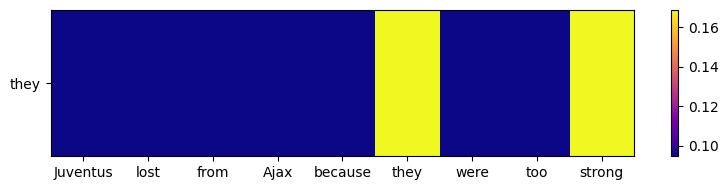

After applying self-attention twice


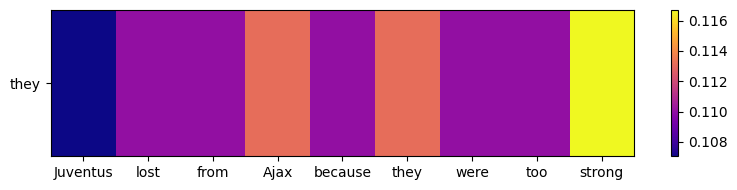

After applying self-attention once


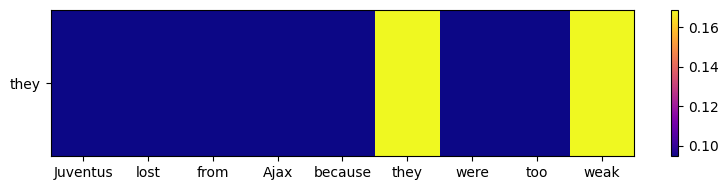

After applying self-attention twice


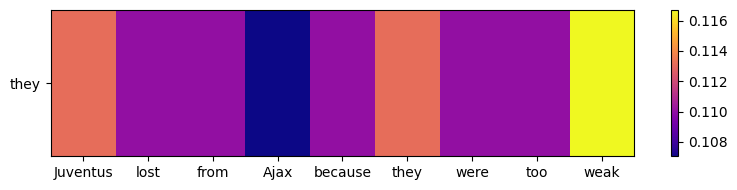

In [11]:
import matplotlib.pyplot as plt
import numpy as np;

np.random.seed(1)
plt.rcParams["figure.figsize"] = 8, 2

xaxis = np.array(range(0, 9))
first, last, step = xaxis[0], xaxis[-1], xaxis[1] - xaxis[0]
extent = [first - step / 2., last + step / 2., 0, 1]

s1 = "Juventus lost from Ajax because they were too strong".split(" ")
s2 = "Juventus lost from Ajax because they were too weak".split(" ")
reps1 = np.array([[1, 0, 0, -1, 0, 0, 0, 0, -1],
                  [0, 0, 0,  0, 0, 1, 0, 0,  1]])  # 2x9
reps2 = np.array([[1, 0, 0, -1, 0, 0, 0, 0,  1],
                  [0, 0, 0,  0, 0, 1, 0, 0,  1]])  # 2x9

Wk = np.array([[1, 0],
               [0, 1],
               [0, 0]])  # 3x2
Wq = np.array([[1, 0],
               [0, 1],
               [0, 0]])  # 3x2
Wv = np.array([[1, 0],
               [0, 1]])  # 2x2


def softmax(x, axis=0):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=axis)


def attend(reps):
    k = Wk @ reps  # 3x2 x 2x9 = 3x9
    q = Wq @ reps  # 3x2 x 2x9 = 3x9
    v = Wv @ reps  # 2x2 x 2x9 = 2x9
    scaler = np.sqrt(Wq.shape[0])
    a = softmax((k.transpose() @ q) / scaler, axis=0)  # 9x3 x 3x9 = 9x9
    o = v @ a  # 2x9 x 9x9 = 2x9
    return a, o


def colormap(y):
    plt.imshow(y[np.newaxis, :], cmap="plasma", aspect="auto", extent=extent)
    plt.xticks(xaxis, s)
    plt.yticks([.5], ['they'])
    plt.colorbar()
    plt.tight_layout()
    plt.show()


for s, reps in zip((s1, s2), (reps1, reps2)):
    a1, v1 = attend(reps)
    a2, v2 = attend(v1)
    print("After applying self-attention once")
    colormap(a1[:, 5])  # 5 is the index of the word "they". We want to plot the attention when "they" is the query
    print("After applying self-attention twice")
    colormap(a2[:, 5])


Below is the solution in text form, as well as a handwritten writing-out of the formulas:

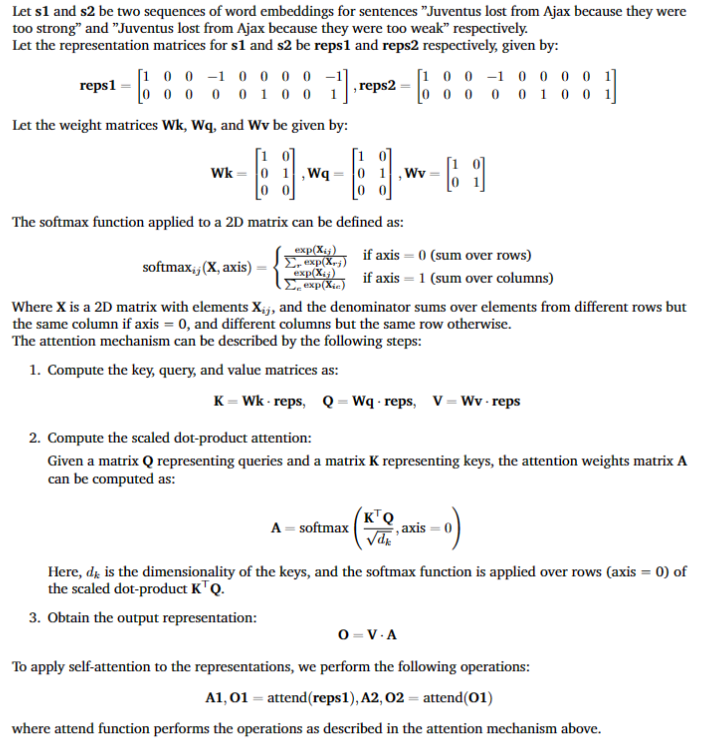

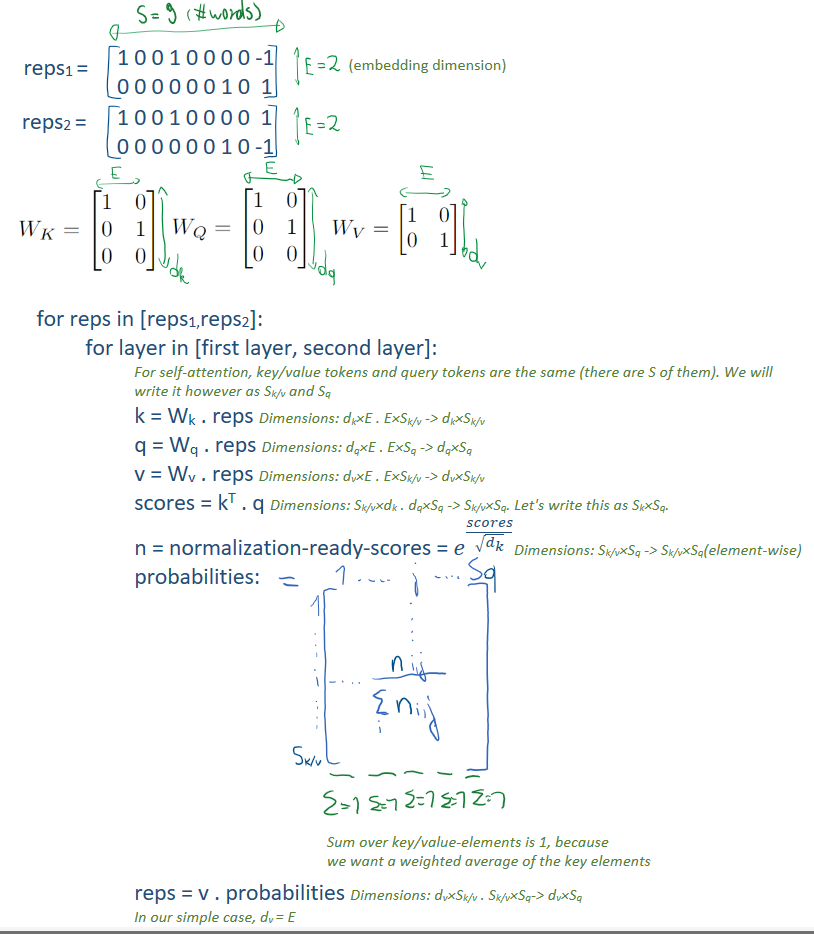

## Multi-head self-attention
### Question 2
![](https://docs.google.com/drawings/d/e/2PACX-1vSFtIqh5XT-ON5Ic-oFfHk7VQh3Arvb0bxfiOUWtpm5TT-R6U0WBY8WuoN3DpTMb8qZeYqcezDwHt21/pub?w=1859&h=744)


## Pretraining, freezing and finetuning

### Question 3
We call these objectives 'self-supervised' because the ground-truth labels that need to be guessed by the pretraining objective are provided without human labelers.
For example, we can let the model mask random words in text, and have it then try to guess what is behind the mask.
The benefit is that it is much cheaper to generate input-target_label combos, and hence we will be able to generate many more than if we were to need manual labeling.

### Question 4
You can leverage the unlabeled tweets by training a model that tries to solve a self-supervised task (such as Language Modelling), and subsequently reusing part of those trained parameters when you start trainnig on the target task (sentiment classification).

### Question 5
For inference, both the full-fine-tuning approach and the LoRa approach are best. Because the LoRa matrices are merged into the original matrix during inference, they do not lead to additional inference time.

For storage, we will want to avoid fine-tuning. Both the adapter-method and the LoRa approach can be beneficial, depending on W_out and R.

Full-fine-tuning requires updating 200*50 = 10 000 parameters, while LoRa requires 200*5 + 5*50 = 1250 parameters

# Byte-pair encoding
### Question 6
First, we split the text into words and their frequency, and add a delimiter to each word (we use '_' as the delimiter, '\w' is also often used):

In [12]:
corpus = "abbc abb abc abb"
counts = dict()
for i in corpus.split(" "):
  i += "_"
  counts[i] = counts.get(i, 0) + 1
print("counts: ", counts)

counts:  {'abbc_': 1, 'abb_': 2, 'abc_': 1}


Then, we list byte pairs and their frequencies

In [13]:
def get_bp_freqs(cnt):
  byte_pairs = dict()
  for word, freq in cnt.items():
    for c1,c2 in zip(word[:-1],word[1:]):
      byte_pairs[(c1,c2)] = byte_pairs.get((c1,c2), 0) + freq
  return byte_pairs
byte_pairs = get_bp_freqs(counts)
print("byte_pairs: ", byte_pairs)

byte_pairs:  {('a', 'b'): 4, ('b', 'b'): 3, ('b', 'c'): 2, ('c', '_'): 2, ('b', '_'): 2}


Then, we take the byte pair with the highest frequency, use a new symbol for it, and replace that in our counts.

In [14]:
new_symbols = ['A','B','C','D','E']
new_symbol = new_symbols[0]
symbol_table = []
def get_symbol_table_and_counts(byte_pairs, counts, new_symbol, symbol_table):
  import re
  max_bp = max(byte_pairs, key=byte_pairs.get)
  old_pair = "".join(max_bp)
  symbol_table.append((new_symbol, old_pair))
  for word, freq in dict(counts).items():
    new_word = re.sub(old_pair,new_symbol,word)
    del counts[word]
    counts[new_word] = freq
  return symbol_table, counts
symbol_table, counts = get_symbol_table_and_counts(byte_pairs, counts, new_symbol, symbol_table)
print("symbol_table: ", symbol_table)
print("counts: ", counts)


symbol_table:  [('A', 'ab')]
counts:  {'Abc_': 1, 'Ab_': 2, 'Ac_': 1}


And we recalculate byte pair frequencies

In [15]:
byte_pairs = get_bp_freqs(counts)
print("byte_pairs: ", byte_pairs)

byte_pairs:  {('A', 'b'): 3, ('b', 'c'): 1, ('c', '_'): 2, ('b', '_'): 2, ('A', 'c'): 1}


In [16]:
new_symbol = new_symbols[1]
symbol_table, counts = get_symbol_table_and_counts(byte_pairs, counts, new_symbol, symbol_table)
print("symbol_table: ", symbol_table)
print("counts: ", counts)

symbol_table:  [('A', 'ab'), ('B', 'Ab')]
counts:  {'Bc_': 1, 'B_': 2, 'Ac_': 1}


Once more

In [17]:
byte_pairs = get_bp_freqs(counts)
new_symbol = new_symbols[2]
symbol_table, counts = get_symbol_table_and_counts(byte_pairs, counts, new_symbol, symbol_table)
print("byte_pairs: ", byte_pairs)
print("symbol_table: ", symbol_table)
print("counts: ", counts)

byte_pairs:  {('B', 'c'): 1, ('c', '_'): 2, ('B', '_'): 2, ('A', 'c'): 1}
symbol_table:  [('A', 'ab'), ('B', 'Ab'), ('C', 'c_')]
counts:  {'BC': 1, 'B_': 2, 'AC': 1}


And a final time

In [18]:
byte_pairs = get_bp_freqs(counts)
new_symbol = new_symbols[3]
symbol_table, counts = get_symbol_table_and_counts(byte_pairs, counts, new_symbol, symbol_table)
print("byte_pairs: ", byte_pairs)
print("symbol_table: ", symbol_table)
print("counts: ", counts)

byte_pairs:  {('B', 'C'): 1, ('B', '_'): 2, ('A', 'C'): 1}
symbol_table:  [('A', 'ab'), ('B', 'Ab'), ('C', 'c_'), ('D', 'B_')]
counts:  {'BC': 1, 'D': 2, 'AC': 1}


Printed out, it looks like so:

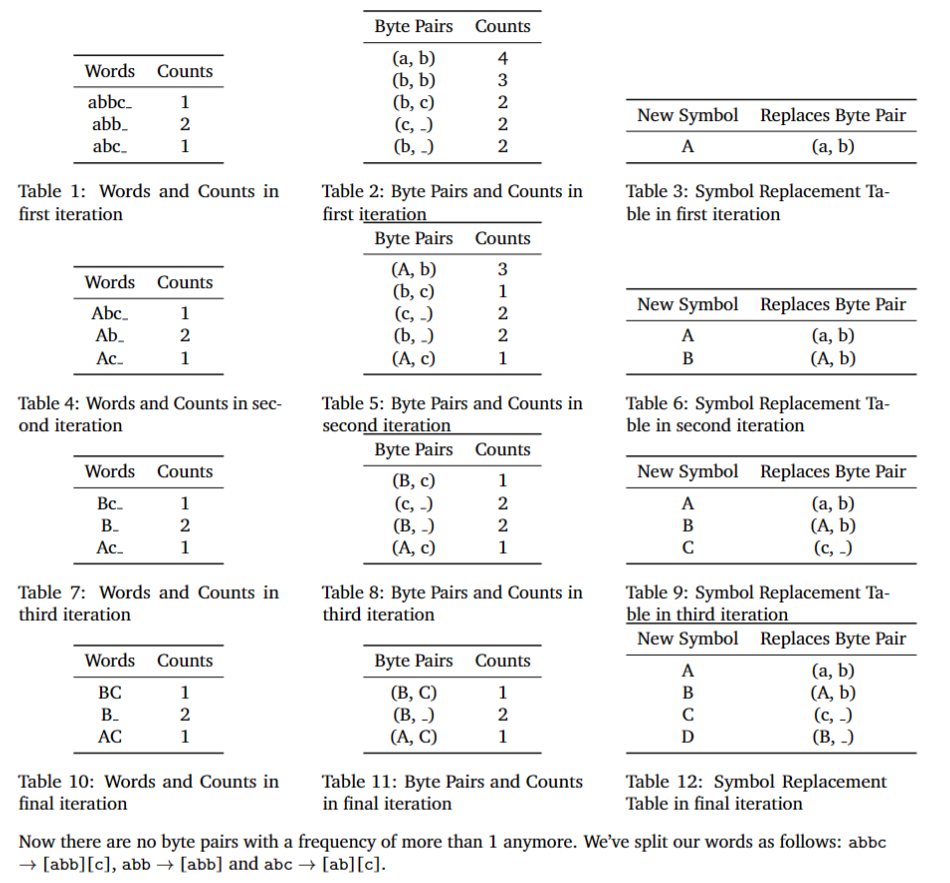

# Cross-modal search
### Question 7

In [19]:
import numpy as np
I = np.array([[0.2,   -1.5, 0.6,  0.3],
              [-0.4,  -0.5, 1.2,  -0.1]])
T = np.array([[0.9,   0.3],
              [-0.8,  -0.1],
              [0.3,   -0.5]])
Wi = np.array([[0.6, 0.3, -0.2],
               [1.3, 0.3, -0.6],
               [0.8, 0.2, -0.3],
               [0.4, 0.4, 0.7]])
Wt = np.array([[-1.2, 0.5,  0.8],
               [0.4,  -0.1, -1.6]])
I_emb = I @ Wi # (Ni, Di) @ (Di, De) = (Ni, De)
T_emb = T @ Wt # (Nt, Dt) @ (Dt, De) = (Nt, De)
print("I_emb\r\n", I_emb)
print("T_emb\r\n", T_emb)
normalized_I_emb = I_emb / np.sqrt((I_emb**2).sum(1))[:,np.newaxis]
normalized_T_emb = T_emb / np.sqrt((T_emb**2).sum(1))[:,np.newaxis]
print("normalized I_emb\r\n", normalized_I_emb)
print("normalized T_emb\r\n", normalized_T_emb)
cos_match = normalized_I_emb @ normalized_T_emb.T # (Ni, De) @ (De, Nt) = (Ni, Nt)
print("cos_match matrix\r\n", cos_match)
# Max match per image
max_match = np.argmax(cos_match, axis=1)
print("max_match indexes\r\n",max_match)

I_emb
 [[-1.23 -0.15  0.89]
 [ 0.03 -0.07 -0.05]]
T_emb
 [[-0.96  0.42  0.24]
 [ 0.92 -0.39 -0.48]
 [-0.56  0.2   1.04]]
normalized I_emb
 [[-0.80623244 -0.09832103  0.58337144]
 [ 0.32929278 -0.76834982 -0.5488213 ]]
normalized T_emb
 [[-0.89303292  0.3907019   0.22325823]
 [ 0.82990724 -0.35180851 -0.43299508]
 [-0.46744639  0.16694514  0.86811473]]
cos_match matrix
 [[ 0.81182036 -0.88710493  0.86688957]
 [-0.7167939   0.78123139 -0.75863885]]
max_match indexes
 [2 1]


And the printed solution:
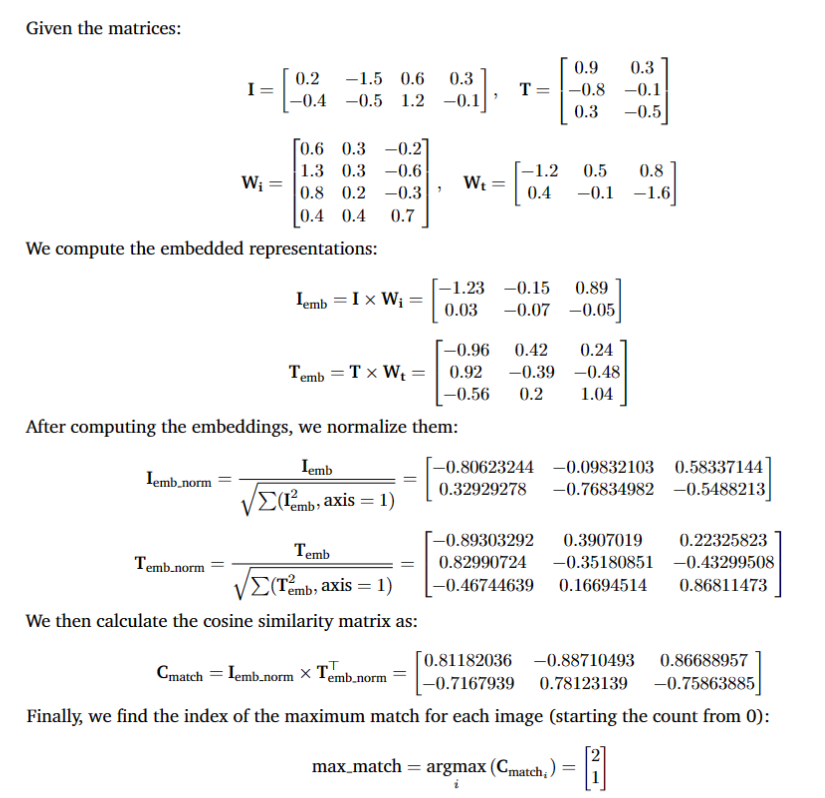

## Question 8
For cross-attention, we could reuse the image projection as the query projection, and the text projection as the key projection.

We can also reuse the calculation of similarity between each image and each sentence.

We would need to add a value projection to apply to the text embeddings, as well as a softmax to the similarity scores so we can take a weighted average of the output of the value projection.

Finally, we might use an output projection matrix.

# OPTIONAL: LSTM Gates
## Question 9

In [20]:
import numpy as np
def tanh(x):
  return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

Cprev = np.array([1.3,.6,-.5])
f = np.array([0.8,0.1,0.9])
i = np.array([0.3,0.7,0.6])
Cprime = np.array([0.6,0.1,-0.3])
o = np.array([0.2,0.1,0.7])

prev_term = Cprev*f
new_term = i*Cprime
C = prev_term+ new_term
print("prev_term", prev_term)
print("new_term", new_term)
print("C", C)
h = tanh(C)*o
print(C,h)

prev_term [ 1.04  0.06 -0.45]
new_term [ 0.18  0.07 -0.18]
C [ 1.22  0.13 -0.63]
[ 1.22  0.13 -0.63] [ 0.16793084  0.01292726 -0.39063655]
